In [1]:
from sklearn import linear_model
from code.data_module import CrowdTangleDataModule, GroupId2Name, inverse_transform
from tqdm import tqdm
import pytorch_lightning as pl
import torch
import pandas as pd
import seaborn as sb
from pathlib import Path

## 1. Training

We setup our datamodule and convert the training set to numpy arrays. We only keep the encoded categorical features as linear regression can not handle text.

In [2]:
config = {
    'batch_size': 128,
    #'dataset_path': '../data/crowdtanglev2_filtered.csv',
    'dataset_path': '../data/crowdtangle_rtnews_v1_filtered.csv',
    'category_group_id': False # group id not encoded (we only have one page = rtnews)
}
data_module = CrowdTangleDataModule(num_workers=0,config=config)
data_module.setup('')

X = []
y = []
for y_lst, encoded_texts_lst, category_vectors_lst, _ in tqdm(iter(data_module.train_dataloader()), total=len(data_module.train_dataloader())):
    #iterate over all >batches<
    X += [v.numpy() for v in category_vectors_lst]
    y += [y.numpy() for y in y_lst]
    
X[:3], y[:3]

100%|██████████| 271/271 [00:59<00:00,  4.53it/s]


([array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        dtype=float32),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        dtype=float32),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        dtype=float32)],
 [array(0.46071428, dtype=float32),
  array(0.17464985, dtype=float32),
  array(0.4147934, dtype=float32)])

In [3]:
# we only have categorical values (=> 0 or 1) => no normalization needed
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X, y)

Lasso(alpha=0.1)

In [4]:
linreg = linear_model.LinearRegression(normalize=False)
linreg.fit(X, y)

LinearRegression()

## 2. Evaluation

In [5]:
reg = lasso
mse = pl.metrics.MeanSquaredError()
#groupid2name = GroupId2Name(config)
df_dicts = []
for y_lst, encoded_texts_lst, category_vectors_lst, _ in tqdm(iter(data_module.test_dataloader()), total=len(data_module.test_dataloader())):
    y_hat_lst = reg.predict([v.numpy() for v in category_vectors_lst])
    mse(torch.from_numpy(y_hat_lst), y_lst)
    for y_hat, y_gold, encoded_text, category_vector in zip(y_hat_lst, y_lst, encoded_texts_lst['input_ids'], category_vectors_lst):
        decoded_categories = inverse_transform(category_vector.reshape(1, -1), config, data_module.class_encoder)
        df_dicts.append({**{
            'prediction': float(y_hat),
            'gold label': float(y_gold),
            'text': data_module.tokenizer.decode(encoded_text).replace(' [PAD]','')
        },**decoded_categories})
    
mse.compute()


100%|██████████| 91/91 [00:27<00:00,  3.34it/s]


tensor(177.5171)

In [6]:
float(mse.compute())

177.5171356201172

In [7]:
dataset_path = Path(config['dataset_path'])
dataset_name = dataset_path.stem
figure_path = Path('./figures/' + dataset_name + '/')
figure_path.mkdir(parents=True, exist_ok=True)

In [8]:
df = pd.DataFrame.from_dict(df_dicts)
df

,prediction,gold label,text,post_type,domain
0,0.794125,0.325210,[CLS] and that one remaining percent is going ...,Link,rt
1,1.331309,0.777644,"[CLS] jon "" bones "" jones helps small business...",Native Video,facebook
2,1.331309,0.636870,[CLS] autonomous grocery delivery vehicle # ch...,Native Video,facebook
3,0.794125,0.293592,[CLS] developing uk claims men in rt interview...,Link,rt
4,1.331309,0.215301,[CLS] rt play when a dog knows road rules bett...,Native Video,facebook
...,...,...,...,...,...
11525,1.331309,0.798722,[CLS]'kim'and'boris'meet with protesters in ho...,Native Video,facebook
11526,0.794125,0.298862,[CLS] big bezos is watching! amazon uses augme...,Link,rt
11527,1.331309,0.068505,[CLS] rt uk live : theresa may holds # pmqs af...,Native Video,facebook
11528,0.794125,0.141527,"[CLS] okay, google... google earned $ 4. 7bn f...",Link,rt


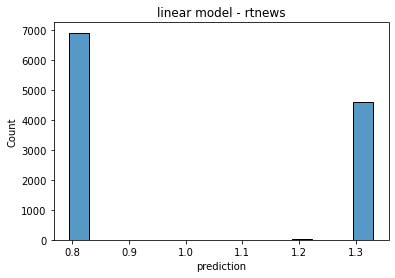

In [9]:
plt = sb.histplot(data=df['prediction'])
plt.set_title('linear model - rtnews')
plt.figure.savefig(f'{figure_path}/linear_model_prediction_dist.pdf')

## MSE per group

In [ ]:
# initialize MSE for each facebook group
groupid2name = GroupId2Name(config)
df_dicts = []
groups_mse = {}
totalmse = pl.metrics.MeanSquaredError()
for group_id, _ in groupid2name.group_id2name.items():
    groups_mse[group_id] = pl.metrics.MeanSquaredError()
    
for y_lst, encoded_texts_lst, category_vectors_lst, _ in tqdm(iter(data_module.test_dataloader()), total=len(data_module.test_dataloader())):
    y_hat_lst = reg.predict([v.numpy() for v in category_vectors_lst])
    totalmse(torch.from_numpy(y_hat_lst), y_lst)
    
    for y_hat, y, encoded_text, category_vector in zip(y_hat_lst, y_lst, encoded_texts_lst['input_ids'], category_vectors_lst):
        
        decoded_categories = inverse_transform(category_vector.reshape(1, -1), config, data_module.class_encoder)
        group_id = decoded_categories['group_id']
        
        groups_mse[group_id](y_hat.squeeze(), y)
    
        df_dicts.append({**{
            'prediction': float(y_hat),
            'gold label': float(y),
            'text': data_module.tokenizer.decode(encoded_text).replace(' [PAD]','')
        },**decoded_categories})
for group_id, _ in groups_mse.items():
    print(groupid2name(group_id) + ':', float(groups_mse[group_id].compute()))
